In [79]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import cv2
import math
import random
import PIL
from kaggle_datasets import KaggleDatasets

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
except ValueError:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2022-04-11 04:01:36.853841: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-11 04:01:36.856674: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-11 04:01:36.856718: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-11 04:01:36.856746: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (34e18a669ea0): /proc/driver/nvidia/version does not exist
2022-04-11 04:01:36.860264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/monet-gan-getting-started
/kaggle/input/monet-gan-getting-started/monet_jpg
/kaggle/input/monet-gan-getting-started/photo_tfrec
/kaggle/input/monet-gan-getting-started/photo_jpg
/kaggle/input/monet-gan-getting-started/monet_tfrec


In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path('monet-gan-getting-started')
monet_names = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photo_names = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
#monet_names = tf.io.gfile.glob(r"../input/monet-gan-getting-started/monet_tfrec/*.tfrec")
#photo_names = tf.io.gfile.glob(r"../input/monet-gan-getting-started/photo_tfrec/*.tfrec")
#print(monet_names)

print(f"Monet file tfrecords: {len(monet_names)}")
print(f"Photo file tfrecords: {len(photo_names)}")

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

print(f"Monet images: {count_data_items(monet_names)}")
print(f"Photo images: {count_data_items(photo_names)}")

Monet file tfrecords: 5
Photo file tfrecords: 20
Monet images: 300
Photo images: 7038


2022-04-11 04:01:45.544309: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-04-11 04:01:45.625332: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
tf.data.TFRecordDataset(monet_names)

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [6]:
raw_dataset = tf.data.TFRecordDataset(GCS_PATH + '/monet_tfrec/monet12-60.tfrec')
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

for key in example.features.feature:
    print(key)

image
target
image_name


2022-04-11 04:01:46.236621: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 24, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1649649706.233330943","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 24, Output num: 0","grpc_status":3}


In [7]:
BATCH_SIZE =  4
BUFFER_SIZE = 2048
EPOCHS_NUM = 30
IMAGE_SIZE = 256
CHANNELS=3

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 255.0)
    image = tf.reshape(image, [IMAGE_SIZE,IMAGE_SIZE,CHANNELS])
    return image
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
def batch_visualization(path, n_images, is_random=True, figsize=(8, 8)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

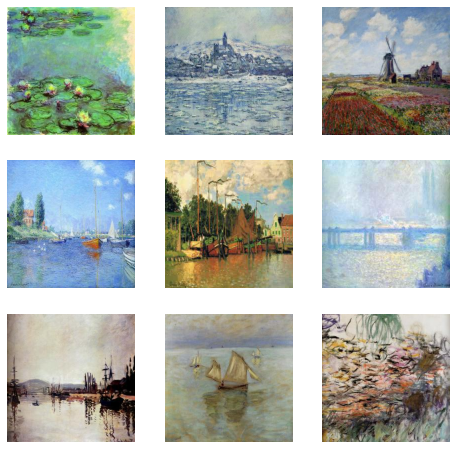

In [9]:
base_path = '../input/monet-gan-getting-started/'
monet_path = os.path.join(base_path, 'monet_jpg')
photo_path = os.path.join(base_path, 'photo_jpg')
batch_visualization(monet_path,9)


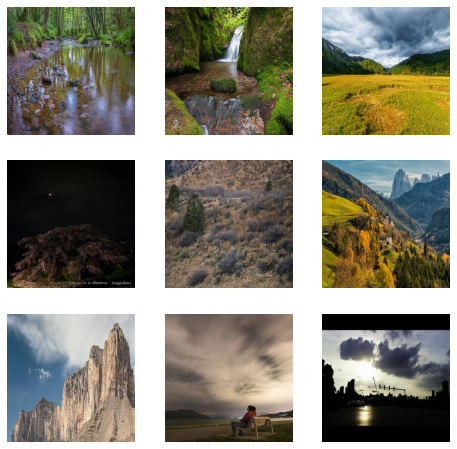

In [10]:
batch_visualization(photo_path,9)

# Augmentations

In [11]:
def data_augment(image):
    #rotate
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_rotate > 0.8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > 0.6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > 0.4:
        image = tf.image.rot90(image, k=1) # rotate 90º
    #crop
    image = tf.image.resize(image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3])
    #flip
    p_flip =tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_flip > 0.6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_flip > 0.9:
            image = tf.image.transpose(image)
    return image

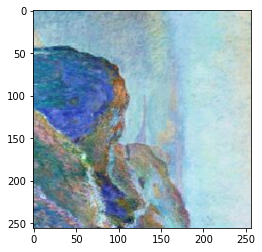

In [12]:
img = cv2.imread('../input/monet-gan-getting-started/monet_jpg/000c1e3bff.jpg')
image1=data_augment(img)
plt.imshow(image1)

# Dataset

In [13]:
monet_ds = load_dataset(monet_names)
photo_ds = load_dataset(photo_names)

In [14]:
train_monet_ds = monet_ds.cache().map(data_augment, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

train_photo_ds = photo_ds.cache().map(data_augment, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

full_ds = tf.data.Dataset.zip((train_monet_ds, train_photo_ds))

In [15]:
def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0])
        plt.axis('off')
        plt.show()

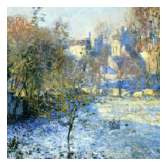

In [16]:
display_samples(train_monet_ds,1)

# Generator model

In [17]:
OUTPUT_CHANNELS = 3

# Upsample & Downsample

In [18]:
initializer = tf.random_normal_initializer(0., 0.02)
gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [19]:
def upsample(layer_input,skip_input,filters, size, apply_dropout=False):
    up = tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(layer_input)
    up = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(up)
    if apply_dropout:
        up = tf.keras.layers.Dropout(0.5)(up)
        
    up = tf.keras.layers.ReLU()(up)
    up = tf.keras.layers.Concatenate()([up,skip_input])
    
    return up

In [20]:
def downsample(layer_input,filters, size, apply_batchnorm=True):
    d = tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False)(layer_input)
    if apply_batchnorm:
        d = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(d)
    d = tf.keras.layers.LeakyReLU()(d)
    
    return d

# Generator Model

In [21]:
def Generator():
    inputs = tf.keras.Input(shape=[256,256,3])
    
    d1 = downsample(inputs,64,4,apply_batchnorm=False)
    d2 = downsample(d1,128,4)
    d3 = downsample(d2,256,4)
    d4 = downsample(d3,512,4)
    d5 = downsample(d4,512,4)
    d6 = downsample(d5,512,4)
    d7 = downsample(d6,512,4)
    d8 = downsample(d7,512,4)
    
    up1=upsample(d8,d7,512,4,apply_dropout=True)
    up2=upsample(up1,d6,512,4,apply_dropout=True)
    up3=upsample(up2,d5,512,4,apply_dropout=True)
    up4=upsample(up3,d4,512,4)
    up5=upsample(up4,d3,256,4)
    up6=upsample(up5,d2,128,4)
    up7=upsample(up6,d1,64,4)
    
    outputs = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh')(up7) # (batch_size, 256, 256, 3)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)
    

In [22]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131072      leaky_re_lu[0][0]                
______________________________________________________________________________________________

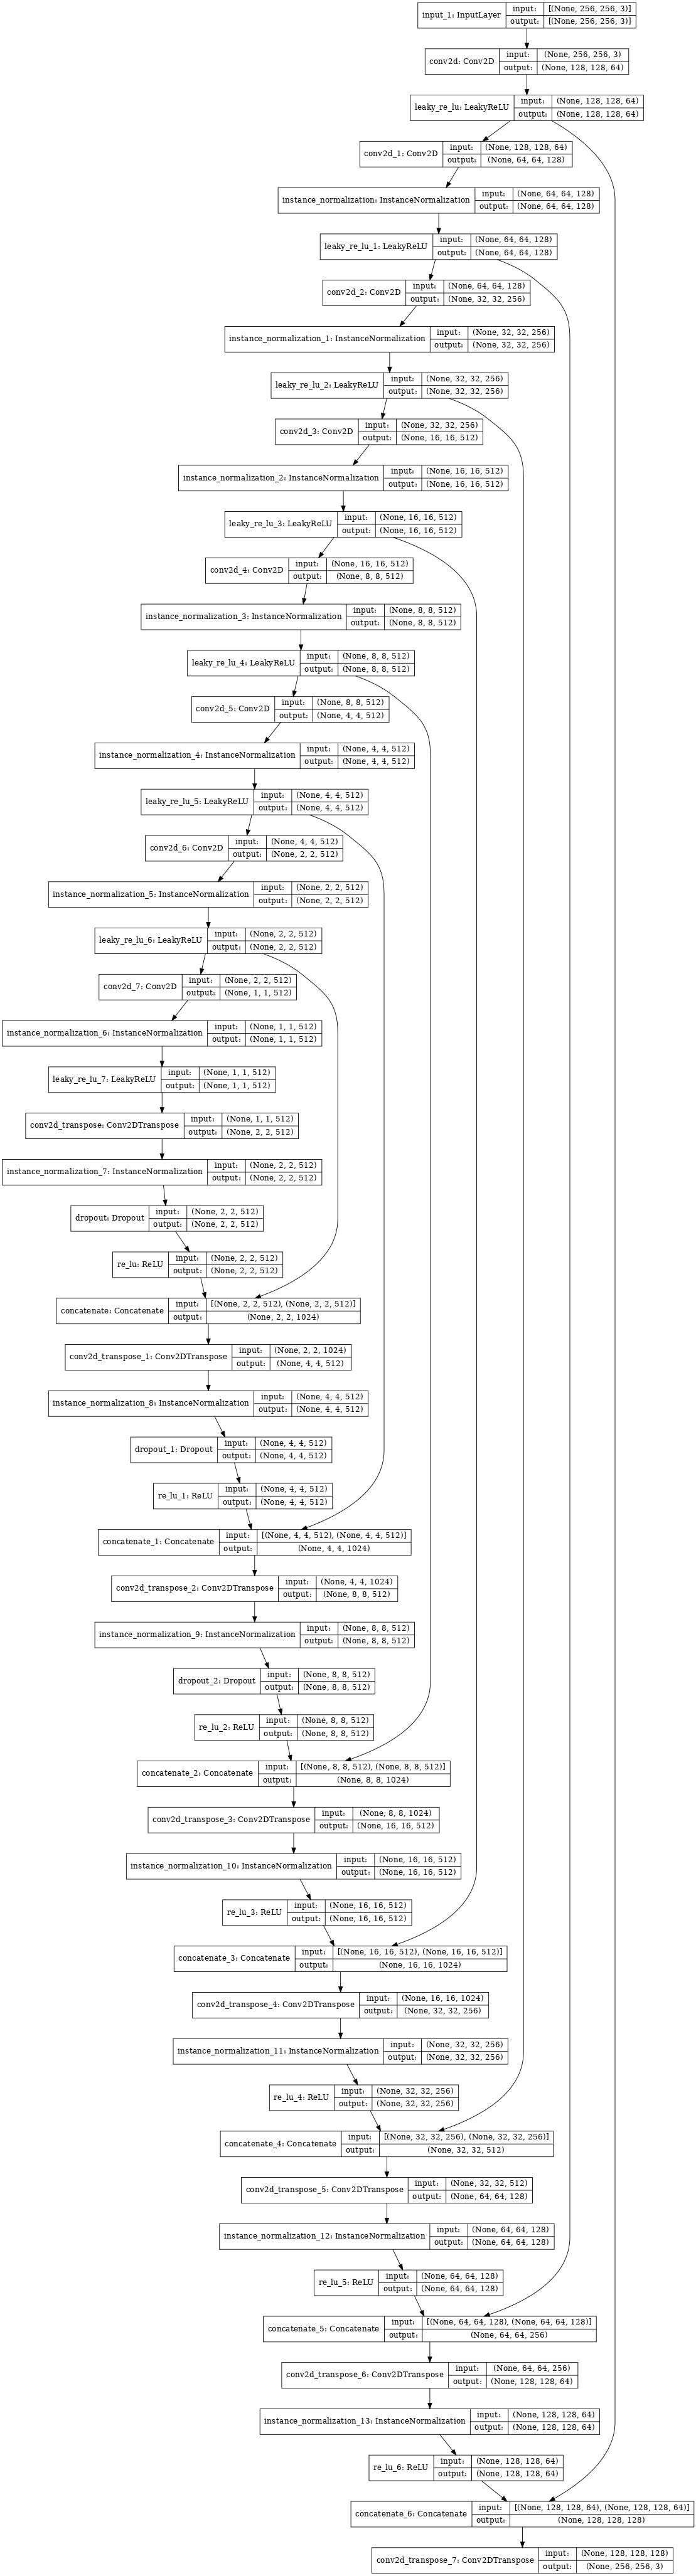

In [23]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# Discriminator

In [24]:
def Discriminator():
    input_image = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    d1 = downsample(input_image,64,4, apply_batchnorm=False)  # (batch_size, 128, 128, 64)
    d2 = downsample(d1,128,4)  # (batch_size, 64, 64, 128)
    d3 = downsample(d2,256,4)  # (batch_size, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(d3)  # (batch_size, 34, 34, 256) #padding='SAME'
    
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
    
    insnorm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(insnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512) #padding='SAME'
    
    outputs = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    
    return tf.keras.Model(inputs=input_image,outputs=outputs)

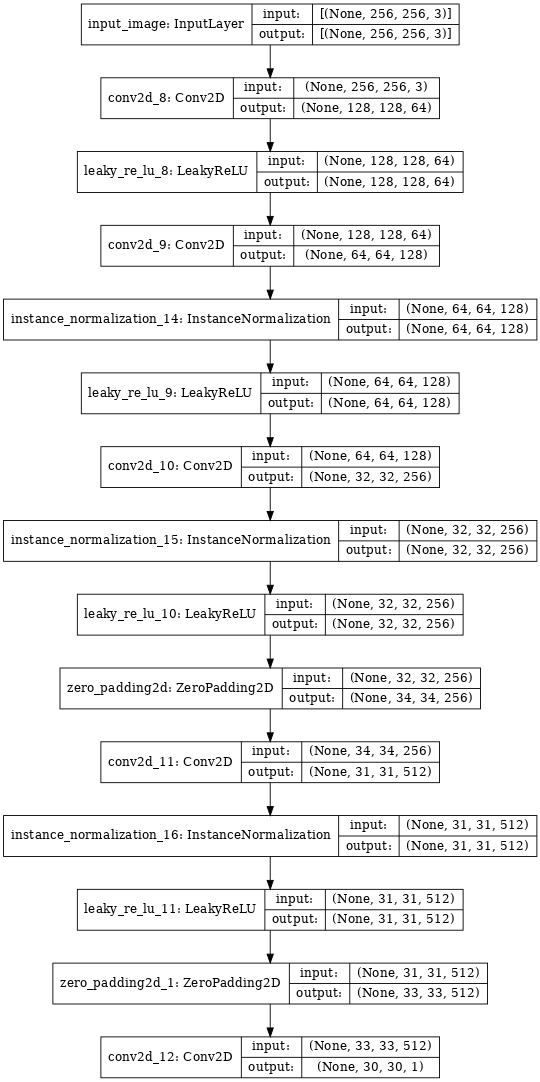

In [25]:
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

# Loss function

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
LAMBDA=10

In [27]:
with strategy.scope():
    def discriminator_loss(real_output, gen_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        gen_loss = cross_entropy(tf.zeros_like(gen_output), gen_output)
        total_loss = real_loss + gen_loss 
        return total_loss*0.5
with strategy.scope():    
    def generator_loss(gen_output):
        return cross_entropy(tf.ones_like(gen_output), gen_output)
with strategy.scope():
    def calc_cycle_loss(real_image, gen_fw_image):
        loss = tf.reduce_mean(tf.abs(real_image - gen_fw_image))
        return LAMBDA * loss
with strategy.scope():
    def identity_loss(real_image, gen_same_type_image):#same type image generated
        loss = tf.reduce_mean(tf.abs(real_image - gen_same_type_image))
        return LAMBDA * 0.5 * loss

# Optimizer

In [28]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Build model (CycleGAN)

In [29]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [30]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        #lambda_cycle=10,
    ):
        
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        #self.lambda_cycle = lambda_cycle
        
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
        ):
        
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            #
            gen_monet = self.m_gen(real_photo, training=True)
            gen_fw_photo = self.p_gen(gen_monet, training=True) 
            
            gen_photo = self.p_gen(real_monet, training=True)
            gen_fw_monet = self.m_gen(gen_photo, training=True)
            
            gen_same_monet = self.m_gen(real_monet, training=True)
            gen_same_photo = self.p_gen(real_photo, training=True)
            
            #
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            
            disc_gen_monet = self.m_disc(gen_monet, training=True)
            disc_gen_photo = self.p_disc(gen_photo, training=True)  
            
            #
            monet_gen_loss = self.gen_loss_fn(disc_gen_monet)
            photo_gen_loss = self.gen_loss_fn(disc_gen_photo) 
            
            total_cycle_loss = self.cycle_loss_fn(real_monet, gen_fw_monet) + self.cycle_loss_fn(real_photo, gen_fw_photo)
            
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, gen_same_monet)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, gen_same_photo)
            
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_gen_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_gen_photo)
            
        #
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }
    
            
            
            
    

# Train

In [31]:
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator,
                         photo_generator,
                         monet_discriminator,
                         photo_discriminator
                        )
    cycle_gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)


In [32]:
history = cycle_gan_model.fit(
    full_ds,
    epochs=25,
    steps_per_epoch=(max(count_data_items(monet_names), count_data_items(photo_names))//BATCH_SIZE)
)

Epoch 1/25
1759/1759 [==============================] - 330s 127ms/step - monet_gen_loss: 2.8151 - photo_gen_loss: 2.9214 - monet_disc_loss: 0.6408 - photo_disc_loss: 0.5992
Epoch 2/25
1759/1759 [==============================] - 222s 126ms/step - monet_gen_loss: 2.3157 - photo_gen_loss: 2.4792 - monet_disc_loss: 0.6478 - photo_disc_loss: 0.5924
Epoch 3/25
1759/1759 [==============================] - 223s 127ms/step - monet_gen_loss: 2.1185 - photo_gen_loss: 2.2677 - monet_disc_loss: 0.6567 - photo_disc_loss: 0.6058
Epoch 4/25
1759/1759 [==============================] - 222s 126ms/step - monet_gen_loss: 1.9684 - photo_gen_loss: 2.1155 - monet_disc_loss: 0.6641 - photo_disc_loss: 0.6211
Epoch 5/25
1759/1759 [==============================] - 222s 126ms/step - monet_gen_loss: 1.8917 - photo_gen_loss: 2.0772 - monet_disc_loss: 0.6615 - photo_disc_loss: 0.6080
Epoch 6/25
1759/1759 [==============================] - 222s 126ms/step - monet_gen_loss: 1.8501 - photo_gen_loss: 2.0691 - monet_

# Generate images

In [72]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(8, 8))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])# * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [61]:
sample_monet = iter(monet_ds.batch(1))
sample_photo = iter(photo_ds.batch(1))


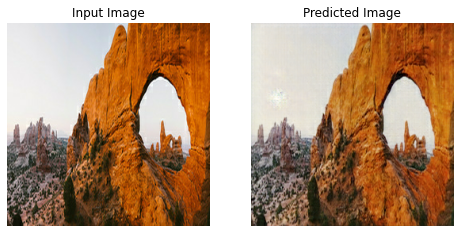

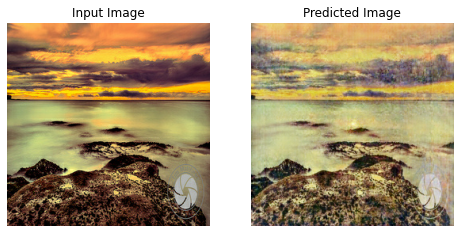

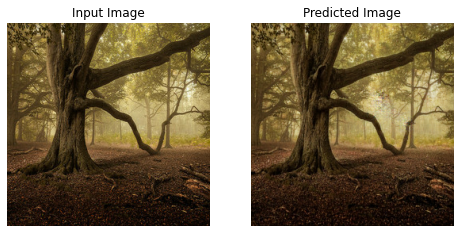

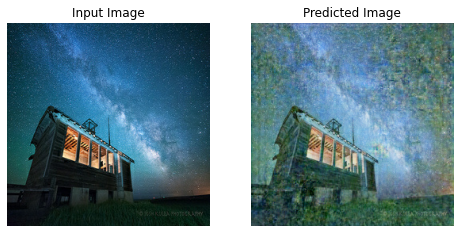

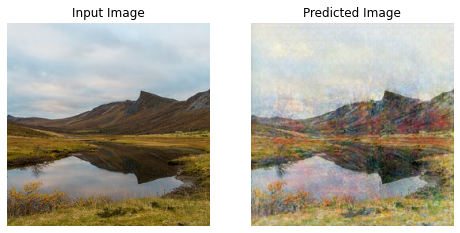

In [73]:
for i in range(5):
    example_sample = next(sample_photo)
    generate_images(monet_generator, example_sample)

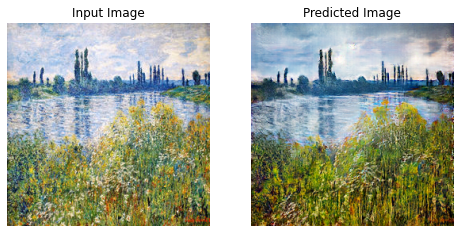

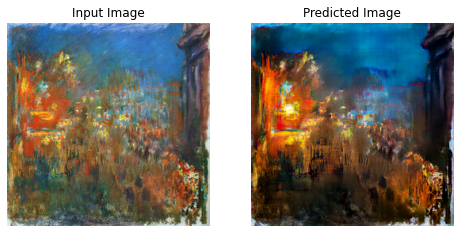

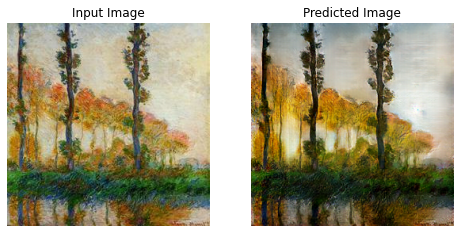

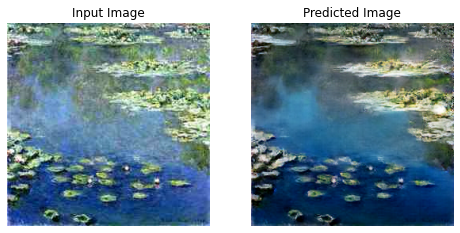

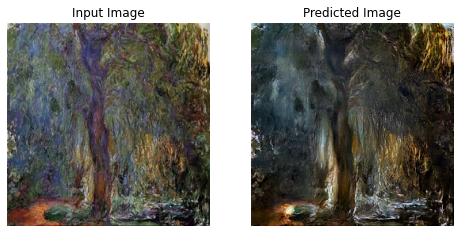

In [74]:
for i in range(5):
    example_sample = next(sample_monet)
    generate_images(photo_generator, example_sample)

# Make predictions

In [80]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [82]:
#if not os.path.isdir('../gen_images/'):
#    os.makedirs('../gen_images/') # Create folder to save generated images
#predict_and_save(photo_ds.batch(1), monet_generator, '../gen_images/')

# Submission file

In [ ]:
#shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

#print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")